In [1]:
import pandas as pd
import numpy as np
import random
from itertools import tee
import math

In [2]:
pd.__version__

'0.25.1'

In [3]:
np.__version__

'1.16.5'

In [474]:
ID = 'Id'
ORIGIN = 'Origin'
DESTINATION = 'Destination'
DEPARTURE = 'Departure'
ARRIVAL = 'Arrival'
RESTRICTED_TIME = 60 * 8
N = 508

In [475]:
file = 'service_trips.csv'

In [476]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [477]:
def get_deadhead(id_1, id_2):
    global trips_df
    return 15 if trips_df.loc[id_1][DESTINATION] != trips_df.loc[id_2][ORIGIN] else 0

In [478]:
def valid_pair(id_1, id_2):
    global trips_df
    return True if trips_df.loc[id_1][ARRIVAL] + get_deadhead(id_1, id_2) <= trips_df.loc[id_2][DEPARTURE] else False

In [479]:
def valid_vehicle(vehicle):
    for trip_1, trip_2 in pairwise(vehicle):
        if not valid_pair(id_1=trip_1, id_2=trip_2):
            return False
    return True

In [480]:
def deadhead_duration(vehicle):
    duration = 30
    for trip_1, trip_2 in pairwise(vehicle):
        duration += get_deadhead(id_1=trip_1, id_2=trip_2)
    return duration

In [481]:
def restricted_vehicle(vehicle):
    global trips_df

    if not valid_vehicle(vehicle=vehicle):
        return False
    
    duration = deadhead_duration(vehicle=vehicle)
    for trip in vehicle:
        duration += trips_df.loc[trip][ARRIVAL] - trips_df.loc[trip][DEPARTURE]
        
    return True if duration <= RESTRICTED_TIME else False

In [482]:
def valid_schedule(schedule):
    for vehicle in schedule:
        if not restricted_vehicle(vehicle):
            return False
    return True

In [483]:
def get_schedule_opex(schedule):
    return sum( [deadhead_duration(vehicle) for vehicle in schedule] )

In [484]:
def get_matrices():
    global trips_df
    neighbors_matrix = pd.DataFrame(False, index=trips_df.index, columns=trips_df.index)
    penalty_matrix = pd.DataFrame(np.nan, index=trips_df.index, columns=trips_df.index)

    u_triu_indices = np.triu_indices(neighbors_matrix.shape[0], 1)
    for i,j in zip(u_triu_indices[0], u_triu_indices[1]):
        pair = valid_pair(id_1=neighbors_matrix.index[i], id_2=neighbors_matrix.columns[j])
        neighbors_matrix.iloc[i,j] = pair
        if pair:
            penalty_matrix.iloc[i,j] = get_deadhead(id_1=penalty_matrix.index[i], id_2=penalty_matrix.columns[j])

    return neighbors_matrix, penalty_matrix

In [485]:
%%time
trips_df = pd.read_csv(file,index_col=0)
trips_df = trips_df.sample(n=N)
trips_df.sort_values(by=DEPARTURE, inplace=True)
# trips_df = trips_df.loc[[1,27,28]]
trips = set(trips_df.index)

Wall time: 8 ms


In [486]:
trips_df.head()

,Origin,Destination,Departure,Arrival
Id,,,,
1,2,9,305,365
368,1,1,320,470
88,3,4,330,390
375,8,8,330,420
481,2,9,335,395


In [487]:
%%time
neighbors_matrix, penalty_matrix = get_matrices()

Wall time: 13min 53s


In [488]:
neighbors_matrix.head()

Id,1,368,88,375,481,484,400,487,380,490,...,448,426,374,37,19,55,73,259,413,462
Id,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
368,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
88,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
375,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
481,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


In [489]:
penalty_matrix.head()

Id,1,368,88,375,481,484,400,487,380,490,...,448,426,374,37,19,55,73,259,413,462
Id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,15.0,15.0,15.0,15.0,0.0,15.0,15.0,15.0,15.0
368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,15.0,0.0,0.0,15.0,15.0,0.0,0.0,15.0,15.0
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,0.0,15.0
375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,15.0,15.0,15.0,15.0,0.0,15.0,15.0,15.0,15.0


In [490]:
def get_trip_candidates(neighbors_matrix, trip, to=True):
    # return all the vaild candidates for trip
    if to:
        return neighbors_matrix.loc[trip][neighbors_matrix.loc[trip] == True].index.tolist()    
    return neighbors_matrix.loc[trip][neighbors_matrix[trip] == True].index.tolist()

In [491]:
def get_restricted_candidates(vehicle, candidates, to=True):
    restricted_candidates = []
    for c in candidates:
        if to:
            tmp_vehicle = vehicle + [c]
        else:
            tmp_vehicle = [c] + vehicle
        if restricted_vehicle(vehicle= tmp_vehicle):
            restricted_candidates.append(c)
    return restricted_candidates

In [492]:
def get_soft_random_vehicle():
    """
    init empty vehicle
    while trips not empty:
    - pick trip. 
    - if trip qualified; add trip to vehicle
    - else stop and return vehicle
    """
    global trips
    
    vehicle = []
    while trips:
        candidate = random.sample(trips, 1)
        if not restricted_vehicle(vehicle=vehicle + candidate):
            break
        vehicle += candidate
        trips-= set(candidate)
    
    return vehicle

In [493]:
%%time
trips = set(trips_df.index)
soft_schedule = []
while trips:
    vehicle = get_soft_random_vehicle()
    soft_schedule.append(vehicle)
print(soft_schedule)
print()
print('opex' , get_schedule_opex(soft_schedule))
print('deadheads' , get_schedule_opex(soft_schedule) / 15)

[[467], [295], [124], [155, 196], [296], [275, 307], [256], [414], [335, 470], [388, 116], [320], [169], [115], [17], [343, 148, 228, 474], [70], [149, 197], [252], [66], [393], [89, 293, 16], [132], [198], [372, 310], [442], [98], [379], [371], [92, 10, 282, 328], [2, 278], [336, 270, 173, 308], [445], [506, 126, 117], [58, 290, 473], [421], [42, 53], [171, 472], [125, 229, 447], [161], [487, 424], [429, 30, 71], [360, 475], [312], [361, 15], [111, 118, 73], [269], [500], [188], [303], [430], [84], [128, 329, 426], [219], [241], [22, 160], [168, 143, 34], [503], [381, 410], [250, 114], [423], [281, 462], [104, 110], [120], [205], [94], [27, 240], [234, 130], [239], [31, 412], [407], [8, 217], [245], [305], [341, 9, 185], [202], [191, 468], [416, 164], [409], [345, 140, 327], [449, 225], [56, 352, 127], [276], [175], [18], [301], [243], [227], [492, 208], [485, 390], [348], [207], [166], [262, 48], [224], [460], [50], [204, 444], [211, 479], [14], [151], [370], [382, 247, 297], [283], 

In [494]:
def get_random_vehicle(neighbors_matrix):
    """
    init empty vehicle 
    while trips not empty:
    - get last trip from vehicle. 
    - get valid candidates for last trip
    - get restricted candidates from valid candidates
    - pick random trip and add to vehicle
    """
    global trips

    # random.sample returns a list
    random_trip = random.sample(trips, 1)
    trips-= set(random_trip)
    vehicle = random_trip
    
    while trips:
        last_trip = vehicle[-1]
        valid_candidates = get_trip_candidates(trip=last_trip, neighbors_matrix=neighbors_matrix)
        restricted_candidates = get_restricted_candidates(vehicle=vehicle, candidates=valid_candidates) 
        
        remove_trip(neighbors_matrix=neighbors_matrix, trip=last_trip)
        
        if not restricted_candidates:
            return vehicle
        candidate = random.sample(restricted_candidates, 1)
        vehicle += candidate
        trips-= set(candidate)
   
    return vehicle

In [495]:
def remove_trip(neighbors_matrix, trip):
    neighbors_matrix.drop(trip, inplace=True, axis=0)
    neighbors_matrix.drop(trip, inplace=True, axis=1) 

In [496]:
%%time
trips = set(trips_df.index)
random_schedule = []
df = neighbors_matrix.copy()
while trips:
    vehicle = get_random_vehicle(neighbors_matrix=df)
    random_schedule.append(vehicle)
print(random_schedule)
print()
print('opex' , get_schedule_opex(random_schedule))
print('deadheads' , get_schedule_opex(random_schedule) / 15)

[[22, 345, 110, 175, 18, 19], [138, 226, 202, 52, 331, 332], [466, 440, 218, 34, 426], [280, 30, 70, 37], [24, 455, 55], [478, 392, 14, 53, 54, 462], [211, 465, 129, 324, 459, 333, 259], [196, 80], [503, 60, 108, 225, 480, 413], [275, 295, 184, 475], [328, 448], [457, 446, 399], [156, 107, 314, 391, 120, 460, 374], [79, 461], [370, 306, 424, 72, 73], [9, 252, 373], [173, 66, 325, 97], [447], [123, 36], [32, 33, 71, 98], [506, 230, 17, 412], [118, 187, 445, 398], [135, 208, 308, 309, 310, 87], [491, 152, 411], [104, 293, 319, 228, 15, 16, 474], [11, 283, 423, 425], [96, 397], [221, 419, 176, 472, 35], [170, 195, 444, 330], [311, 182, 443, 307, 258], [257], [241, 410], [27, 468, 471, 329], [364, 285, 326, 473], [171, 131, 50, 86], [297, 421, 396], [193, 284, 408, 409], [89, 213, 442, 304, 305], [467, 378, 395], [217, 121, 458], [219], [387, 139, 303, 327], [189, 185, 198], [163, 119, 203], [143, 69], [148, 12, 13, 422], [84, 85], [92, 366, 279, 240, 51], [106, 361, 377, 229], [435, 127, 

In [497]:
def get_best_dead_end(neighbors_matrix, trips):
    global trips_df
    
    dead_end_candidates = neighbors_matrix.loc[ (neighbors_matrix[neighbors_matrix.columns] == False).all(axis=1) ].index.tolist()

    k = min (math.ceil(math.sqrt(trips_df.shape[0])), len(dead_end_candidates))
    min_deadhead = len(trips)*2*15 + 1
    argmin = -1
    
    for i in range(k):
#         print('i', i)
        trips = set(trips_df.index)
#         print(trips)
        candidate = dead_end_candidates[i]
#         print('candidate', candidate)
        vehicle = get_vehicle(neighbors_matrix=neighbors_matrix.copy(), dead_end_candidate=candidate)
#         print('vehicle', vehicle)
        deadhead = deadhead_duration(vehicle=vehicle)
#         print(deadhead)
        if deadhead < min_deadhead:
            min_deadhead = deadhead
            argmin = i
    
    trips = set(trips_df.index)
#     print(dead_end_candidates)
#     print(argmin)
    return dead_end_candidates[argmin]

In [498]:
def get_vehicle(neighbors_matrix, dead_end_candidate):
    global trips
    global penalty_matrix

    # random.sample returns a list
    trips-= set([dead_end_candidate])
    vehicle = [dead_end_candidate]
    
    while trips:
        last_trip = vehicle[0]
#         print('last_trip', last_trip)
        valid_candidates = get_trip_candidates(trip=last_trip, neighbors_matrix=neighbors_matrix, to=False)
#         print('valid_candidates', valid_candidates)
        restricted_candidates = get_restricted_candidates(vehicle=vehicle, candidates=valid_candidates, to=False) 
#         print('restricted_candidates', restricted_candidates)
        remove_trip(neighbors_matrix=neighbors_matrix, trip=last_trip)
#         print(neighbors_matrix)
        if not restricted_candidates:
            return vehicle
        candidate = get_best_pre_trip(trip=last_trip, candidates=restricted_candidates)
        vehicle.insert(0,candidate)
#         print('vehicle', vehicle)
        trips-= set([candidate])
   
    return vehicle

In [499]:
def get_best_pre_trip(trip, candidates):
    global trips_df
    global penalty_matrix
    
    deadheads = penalty_matrix.loc[candidates][trip]
    min_deadheads_trips = deadheads[deadheads == min(deadheads)].index.tolist()
    return trips_df.loc[min_deadheads_trips][DEPARTURE].idxmax()

In [500]:
# %%time
# trips_df = pd.read_csv(file,index_col=0)
# trips_df.sort_values(by=DEPARTURE, inplace=True)
# trips_df = trips_df.loc[[1,27,28]]
# trips = set(trips_df.index)
# trips_df.loc[1, 'Origin'] = 2
# trips_df.loc[1, 'Destination'] = 9
# trips_df.loc[1, 'Departure'] = 50
# trips_df.loc[1, 'Arrival'] = 70

# trips_df.loc[27, 'Origin'] = 9
# trips_df.loc[27, 'Destination'] = 7
# trips_df.loc[27, 'Departure'] = 100
# trips_df.loc[27, 'Arrival'] = 200

# trips_df.loc[28, 'Origin'] = 1
# trips_df.loc[28, 'Destination'] = 10
# trips_df.loc[28, 'Departure'] = 220
# trips_df.loc[28, 'Arrival'] = 250
# trips_df


In [501]:
# neighbors_matrix, penalty_matrix = get_matrices()
# penalty_matrix

In [502]:
%%time
trips = set(trips_df.index)
schedule = []
neighbors_matrix, penalty_matrix = get_matrices()
df = neighbors_matrix.copy()
while trips:
    dead_end_trip = get_best_dead_end(neighbors_matrix=df, trips=trips)
    vehicle = get_vehicle(neighbors_matrix=df, dead_end_candidate=dead_end_trip)
    schedule.append(vehicle)
print(schedule)
print()
print('opex' , get_schedule_opex(schedule))
print('deadheads' , get_schedule_opex(schedule) / 15)

[[320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 80], [380, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 87], [117, 118, 119, 120, 33, 34, 330, 331, 98], [334, 469, 470, 471, 472, 473, 474, 475], [319, 66, 67, 68, 69, 70, 71, 374], [114, 115, 116, 217, 218, 219, 35, 332, 333, 37], [30, 31, 203, 86, 72, 73], [317, 131, 132, 79, 36, 259], [129, 202, 208, 258], [406, 407, 408, 409, 410, 411, 412, 413], [487, 393, 394, 395, 396, 397, 398, 399], [442, 443, 444, 445, 446, 447, 448], [420, 421, 422, 423, 424, 425, 426], [13, 14, 15, 16, 17, 18, 19], [49, 50, 51, 52, 53, 54, 55], [300, 456, 457, 458, 459, 460, 461, 462], [109, 110, 111, 112, 215, 130, 32, 97], [315, 64, 216, 257, 373], [437, 311, 312, 313, 27, 28, 65, 245], [105, 106, 107, 108, 127, 128, 29, 78], [436, 62, 63, 84, 249], [104, 212, 213, 248, 85], [434, 26, 214, 95, 96], [263, 252, 253], [370, 256, 372], [148, 149, 150, 151, 152, 153, 154], [137, 138, 139, 140, 141, 142, 143], [159, 160, 161, 162, 163, 164, 165], [272, 2

In [503]:
opex = []
schedules = []

s = [[i] for i in trips_df.index]

for vehicle in schedule:
    opex.append(get_schedule_opex(s) / 15)
    schedules.append(s)
    vehicles.append(len(s))
    for trip in vehicle:
        s.remove([trip])
    s.append(vehicle)
  

soft_s = [[i] for i in trips_df.index]
random_s = [[i] for i in trips_df.index]
soft_opex = []
soft_vehicles = []
random_opex = []
random_vehicles = []
for vehicle in soft_schedule:
    soft_opex.append(get_schedule_opex(soft_s) / 15)
    for trip in vehicle:
        soft_s.remove([trip])
    soft_s.append(vehicle)
    
for vehicle in random_schedule:
    random_opex.append(get_schedule_opex(random_s) / 15)
    for trip in vehicle:
        random_s.remove([trip])
    random_s.append(vehicle)

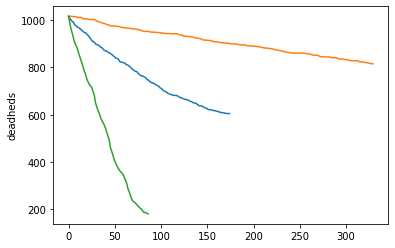

In [504]:
plt.plot(random_opex)
plt.plot(soft_opex)
plt.plot(opex)

plt.ylabel('deadheds')
plt.show()

In [506]:
print(f'daily_schedule -> {valid_schedule(schedule)}')
# print(daily_schedule)
print(f'vehicles: {len(schedule)}')
print(f'opex: {get_schedule_opex(schedule)}')
print(f'deadheads: {get_schedule_opex(schedule)/15}')

daily_schedule -> True
vehicles: 87
opex: 2685
deadheads: 179.0


In [507]:
l = neighbors_matrix.loc[ (neighbors_matrix[neighbors_matrix.columns] == False).all(axis=1) ].index.tolist()
len(l)

15

In [508]:
math.ceil(math.sqrt(trips_df.shape[0]))

23